# Clustering the 'canon' data set

The 'canon' data set is actually all the images of size 3072x2304 in the Dresden image database.
The number of images in this dataset is 2123.

We have already extracted the noise patterns and computed the similarity scores between all the images. We have also computed the coordinates with LargeVis. So now we are looking for a way to cluster the images and evaluate. 

In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as pyplot

In [2]:
filelist_file = "../data/canon/filelist.txt"
#matrix_file = "../data/canon/matrix-canon-pce.dat"
largevis_file = "../data/embedded/coordinates_files/coordinates2D_canon_pce.txt"
output_json_file = "canon-pce.json"

Now let's start by loading the data set, which consists of a simple text file with all the filenames, that also encode the ground truth.

In [3]:
filelist = [str(s) for s in numpy.loadtxt(filelist_file, dtype=numpy.string_)]
nfiles = len(filelist)


Now we are going to obtain the ground truth, which is encoded in the filenames. 

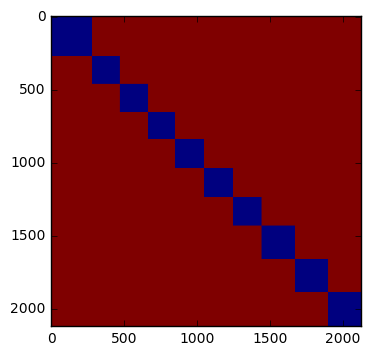

In [4]:
camlist = ["_".join(f.split("_")[:-1]) for f in filelist]

import itertools
ground_truth = list(itertools.product(camlist,camlist))
ground_truth = numpy.array([0 if l[0]==l[1] else 1000 for l in ground_truth]).reshape(nfiles,nfiles)

pyplot.imshow(ground_truth, vmin=0, vmax=80)

## Clustering on embedded data

In [ ]:
#read output from LargeVis for this data set
from clustit.output import OutputCollection
oc = OutputCollection(largevis_file=largevis_file)

In [6]:
from clustit.algorithms import kmeans
labels_embedded_kmeans = kmeans(embedded_space=oc, n_clusters=10)
print(labels_embedded_kmeans)

[0 0 0 ..., 3 3 3]


## Evaluate the clustering using a set of metrics

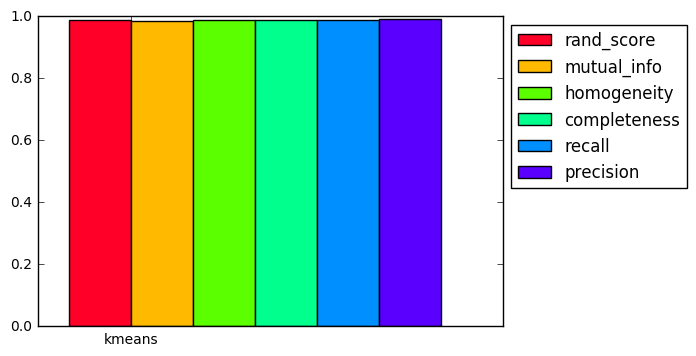

In [12]:
from clustit import metrics
#algorithms = ['complete', 'average', 'centroid', 'dbscan', 'hdbscan', 'spectral', 'affinity']
algorithms = ['kmeans']
#labels = [labels_complete, labels_average, labels_centroid, labels_dbscan, labels_hdbscan, labels_spectral, labels_affinity]
labels = [labels_embedded_kmeans]
metric = ['rand_score', 'mutual_info', 'homogeneity', 'completeness', 'recall', 'precision']

def compute_metrics(algorithms, labels, metric):
    results = {i:[] for i in metric}
    for k,v in zip(algorithms, labels):
        results['rand_score'].append(metrics.adjusted_rand_score(ground_truth_labels, v))
        results['mutual_info'].append(metrics.adjusted_mutual_info_score(ground_truth_labels, v))
        results['homogeneity'].append(metrics.homogeneity_score(ground_truth_labels, v))
        results['completeness'].append(metrics.completeness_score(ground_truth_labels, v))
        results['recall'].append(metrics.recall(ground_truth_labels, v,))
        results['precision'].append(metrics.precision(ground_truth_labels, v))
    return results

results = compute_metrics(algorithms, labels, metric)
    
def plot_results(algorithms, metric, results):
    """
    Function that creates a bar char for a list of algorithms
    that have been benchmarked using a list of metrics. 
    Results is a dictionary with metrics as keys, values are lists
    that contain one value per algorithm.
    """
    width = 1.0/(len(algorithms)+2)                             #width that leaves bar of whitespace between groups
    x_ind = numpy.arange(len(algorithms)) + 0.5*width           #0.5 width is to make bargroup centered on its tick
    bars = []
    for i in range(len(metric)):
        color = 1.0/len(metric)*i                                #map i into [0,1] to get distinct colors
        bars.append(pyplot.bar(x_ind+i*width, results[metric[i]], width=width, color=pyplot.cm.gist_rainbow(color)))
    ax = pyplot.gcf().gca()
    ax.set_xticks(x_ind + (len(x_ind)/float(2)+0.5)*width)      #nicely center the xticks among the bars
    ax.set_xticklabels(algorithms)
    ax.legend(bars, metric, loc='upper left', bbox_to_anchor=(1, 1))
    
plot_results(algorithms, metric, results)


In [13]:
print(results)

{'recall': [0.9878708501793747], 'completeness': [0.98698248269031807], 'mutual_info': [0.98687222120016038], 'rand_score': [0.9878786748964234], 'homogeneity': [0.98747539408502227], 'precision': [0.990343531395599]}


## Produce output for DiVE

In [16]:
#add the ground truth as a property to the output for comparison
oc.add_property("ground truth", ground_truth_labels)

#add the labelings from the clustering algorithms as properties to the output collection
for n,l in zip(algorithms + embed_algorithms, labels + embed_labels):
    oc.add_property(n, l)

#generate a JSON file that can directly be imported by DiVE
json_str = oc.to_DiVE(filename=output_json_file)